In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Shallow Neural Network with skip connection
class ShallowNN(nn.Module):
    def __init__(self, init_zero=False, m=20, out_dim=1):
        super(ShallowNN, self).__init__()
        self.fc1 = nn.Linear(2, m)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(m, out_dim, bias=False)  # Hidden layer to output layer

        if init_zero:
            self.fc1.weight.data = torch.zeros_like(self.fc1.weight.data)
            self.fc1.bias.data = torch.zeros_like(self.fc1.bias.data)

            self.fc2.weight.data = torch.zeros_like(self.fc2.weight.data)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## 2-Squares Dataset

In [3]:
n = 8 # samples
d = 3  # dimensionality + 1 for bias term


X_train = np.asarray([
        [ -1, 1],
        [ -1, -1],
        [1, -1],
        [1, 1],
        [2, 2],
        [2, -2],
        [-2, -2],
        [-2, 2]])

X_train = np.append(X_train, np.ones((n,1)),axis=1)

# y = ((np.linalg.norm(X[:,0:d-1],axis=1)>1)-0.5)*2
train_labels = np.asarray([1, 1, 1, 1, 0, 0, 0, 0])

# Weight decay regularization
lam=1e-3

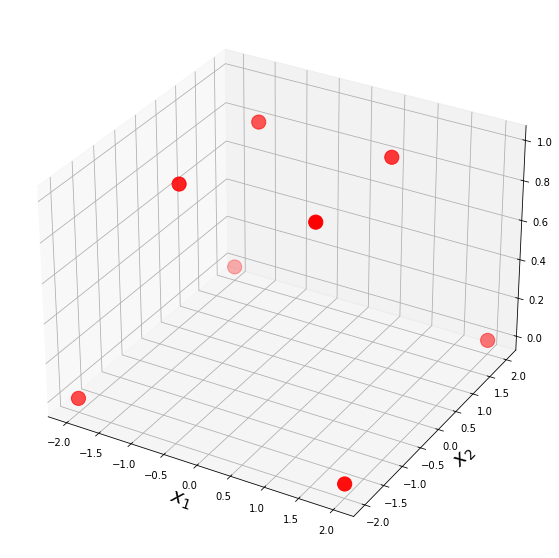

In [4]:
#create 3D scatterplot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_train[:,0], X_train[:,1], train_labels, marker='o', s=200, color='red')
ax.set_xlabel(r'$x_1$', fontsize=20)
ax.set_ylabel(r'$x_2$', fontsize=20)
plt.show()

## Interpolate with Convex Neural Nets
[Code adapted from Tolga Ergen (Mert Pilanci's Group)](https://github.com/pilancilab/convex_nn/blob/main/convex_nn.py)

In [5]:
dmat_all_possible = np.empty((n*d,0))

activ_patt = np.empty((n,0))

for i in range(2**n):
    bin_rep = [*np.binary_repr(i, width=n)]
    bin_rep_np = np.asarray([int(a) for a in bin_rep], dtype=np.float32)
    
    patt_subspace = ((2*np.diag(bin_rep_np) - np.diag(np.ones(n))) @ X_train).flatten()[:,np.newaxis]
    
    dmat_all_possible = np.append(dmat_all_possible, patt_subspace, axis=1)
    activ_patt = np.append(activ_patt, bin_rep_np[:, np.newaxis], axis=1)

dmat = activ_patt

In [6]:
# Optimal CVX
m1=dmat.shape[1]
Uopt1=cp.Variable((d,m1))
Uopt2=cp.Variable((d,m1))

yopt1=cp.Parameter((n,1))
yopt2=cp.Parameter((n,1))

yopt1=cp.sum(cp.multiply(dmat,(X_train @ Uopt1)),axis=1)
yopt2=cp.sum(cp.multiply(dmat,(X_train @ Uopt2)),axis=1)

## Below we use MSE loss

# Regularization includes bias
#cost=cp.sum_squares((yopt1 - yopt2) - train_labels)/n+lam*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))

# No regularization on the bias
cost=cp.sum_squares((yopt1 - yopt2) - train_labels)/n+lam*(cp.mixed_norm(Uopt1[:-1].T,2,1)+cp.mixed_norm(Uopt2[:-1].T,2,1))


constraints=[]
constraints+=[cp.multiply((2*dmat-np.ones((n,m1))),(X_train @ Uopt1))>=0]
constraints+=[cp.multiply((2*dmat-np.ones((n,m1))),(X_train @ Uopt2))>=0]

prob=cp.Problem(cp.Minimize(cost),constraints)

prob.solve(verbose=True, solver=cp.ECOS)

cvx_opt=prob.value
print("Convex program objective value (eq (8)): ",cvx_opt)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Oct 29 04:22:12 PM: Your problem has 1536 variables, 2 constraints, and 0 parameters.
(CVXPY) Oct 29 04:22:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 29 04:22:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 29 04:22:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 29 04:22:12 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 29 04:22:12 PM: Compiling problem (target solver=ECOS).
(C

/home/jshenouda/anaconda3/envs/proxy_task/lib/python3.9/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [7]:
print('Fit to the data: {}'.format((cp.sum_squares(train_labels-(yopt1-yopt2))/n).value))

Fit to the data: 3.99999564601187e-06


In [8]:
print('Regularization Term w.o. Bias: {}'.format(((cp.mixed_norm(Uopt1[:-1].T,2,1)+cp.mixed_norm(Uopt2[:-1].T,2,1))).value))

Regularization Term w.o. Bias: 1.9920000568269272


In [9]:
vs = Uopt1.value
ws = Uopt2.value

In [13]:
# Create a neural network with weights from convex NN

# Initialize the network
model = ShallowNN(m=35,init_zero=True)

## Set the input and output weights according to the convex problem
active_v = 0
for v in vs.T:
    if np.linalg.norm(v) > 1e-3:
        print('Active v: {}'.format(active_v))
        print(v, 'Norm v is: {}'.format(np.linalg.norm(v)))
        v_scaled = v / np.sqrt(np.linalg.norm(v))
        model.fc1.weight.data[active_v] = torch.tensor(v_scaled[:2])
        model.fc1.bias.data[active_v] = torch.tensor(v_scaled[2])

        model.fc2.weight.data[:,active_v] = torch.sqrt(torch.tensor(np.linalg.norm(v)))
        
        active_v += 1
        

active_w = active_v

for w in ws.T:
    if np.linalg.norm(w) > 1e-3:
        print('Active w: {}'.format(active_w))
        print(w, 'Norm w is: {}'.format(np.linalg.norm(w)))
        w_scaled = w / np.sqrt(np.linalg.norm(w))
        model.fc1.weight.data[active_w] = torch.tensor(w_scaled[:2])
        model.fc1.bias.data[active_w] = torch.tensor(w_scaled[2])
        
        model.fc2.weight.data[:,active_w] = - torch.sqrt(torch.tensor(np.linalg.norm(w)))
        
        active_w += 1

Active v: 0
[-2.91234375e-30  5.17121951e-30 -1.91282635e-02] Norm v is: 0.019128263458520308
Active v: 1
[ 5.12890084e-23 -5.51325965e-23  1.19721383e+00] Norm v is: 1.1972138330678934
Active w: 2
[-2.91234375e-30  5.17121951e-30 -1.91282635e-02] Norm w is: 0.019128263458520308
Active w: 3
[-1.13031077e-01 -7.70274090e-18 -1.13031078e-01] Norm w is: 0.15985008277111412
Active w: 4
[-1.03543351e-18 -1.13031077e-01 -1.13031078e-01] Norm w is: 0.15985008283209504
Active w: 5
[-9.81460904e-18  1.13031078e-01 -1.13031078e-01] Norm w is: 0.15985008289099475
Active w: 6
[ 1.13031077e-01  1.53518435e-18 -1.13031078e-01] Norm w is: 0.159850082737394
Active w: 7
[ 2.14391830e-06  1.15068141e-01 -1.15065997e-01] Norm w is: 0.1627294097709101
Active w: 8
[ 1.15068141e-01  2.14391862e-06 -1.15065997e-01] Norm w is: 0.16272940970321195
Active w: 9
[ 2.14385986e-06 -1.15068140e-01 -1.15065997e-01] Norm w is: 0.16272940882330877
Active w: 10
[ 1.15068140e-01 -2.14386019e-06 -1.15065996e-01] Norm w is

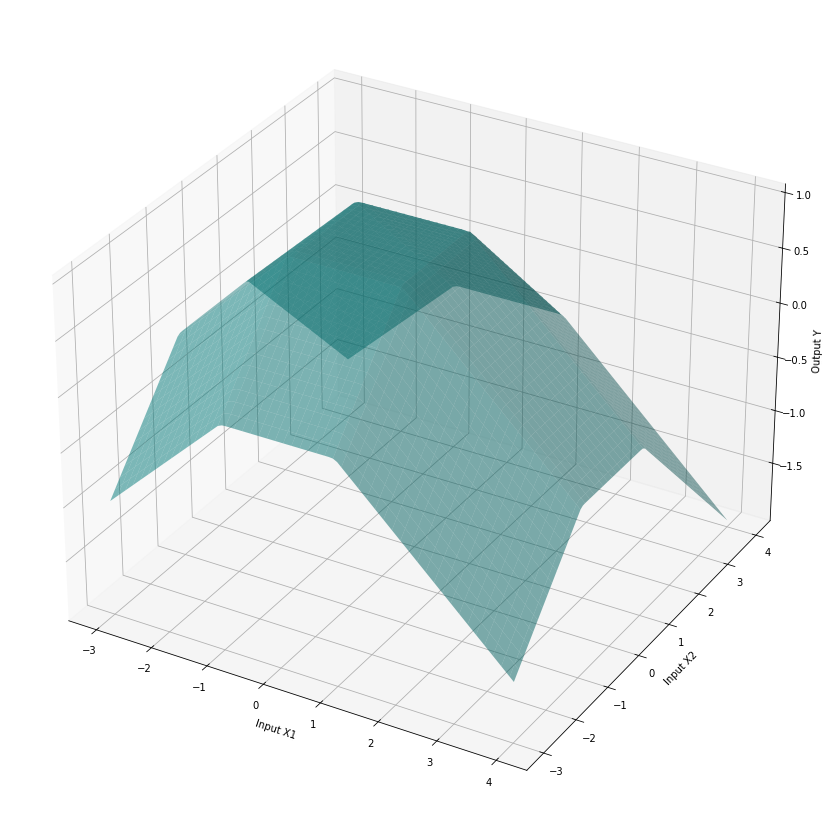

In [14]:
# Create a dense grid of input points
x = np.linspace(-3, 4, 100)  # Adjust the range and density as needed
y = np.linspace(-3, 4, 100)
X_test, Y_test = np.meshgrid(x, y)

# Convert to PyTorch tensors
input_grid = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)

# Evaluate the model on the input grid
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    Z = model(input_grid).numpy()

# Reshape Z for the surface plot
Z = Z.reshape(X_test.shape)

# Create the surface plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_test, Y_test, Z, color='teal', alpha=0.5)

ax.set_xlabel('Input X1')
ax.set_ylabel('Input X2')
ax.set_zlabel('Output Y')
plt.show()

In [17]:
ws_nn = model.fc1.weight.data
vs_nn = model.fc2.weight.data.T

rep_cost = torch.sum(torch.linalg.norm(vs_nn, dim=1) * torch.linalg.norm(ws_nn, dim=1))
print('Rep Cost is: {}'.format(path_norm))

Rep Cost is: 2.4767394065856934


## Train with SGD

In [18]:
train_outputs = torch.tensor(train_labels).unsqueeze(dim=1).to(torch.float32) 

# don't include the last column thats for bias when its not built in
train_inputs = torch.tensor(X_train[:,:-1]).to(torch.float32) 

model_sgd = ShallowNN(m=8)

func_norm = []

# Loss and Optimizer
criterion = nn.MSELoss()
#optimizer = optim.Adam(model_sgd.parameters(), lr=0.0001, weight_decay=1e-3)
optimizer = optim.Adam([
    {'params': model_sgd.fc1.weight, 'weight_decay': 1e-3},  # Applying weight decay
    {'params': model_sgd.fc2.weight, 'weight_decay': 1e-3},
    {'params': model_sgd.fc1.bias, 'weight_decay':0}         # No weight decay
], lr=0.0001)


# Training Loop
for epoch in range(200000):  # Number of epochs
    optimizer.zero_grad()
    output = model_sgd(train_inputs)
#     print('Output from model is: {}'.format(output))
    loss = criterion(output, train_outputs)
#     print(loss.item())
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        ws_nn = model_sgd.fc1.weight.data
        #ws_b = torch.cat((model_sgd.fc1.weight.data, model_sgd.fc1.bias.data.unsqueeze(1)),dim=1)
        vs_nn = model_sgd.fc2.weight.data.T

        path_norm = torch.sum(torch.linalg.norm(vs_nn, dim=1) * torch.linalg.norm(ws_nn, dim=1))
        func_norm.append(path_norm.item())

    if epoch % 10000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Rep Cost is: {path_norm.item()}')

print("Training Complete")

# Calculate the sum of squared weights for the fc1 layer
sum_of_squares_fc1 = torch.sum(model_sgd.fc1.weight ** 2)
sum_of_squares_fc2 = torch.sum(model_sgd.fc2.weight ** 2)

# Total sum of squares for fc1 and the first output weights of fc2
total_sum_of_squares = sum_of_squares_fc1 + sum_of_squares_fc2

print(f"Sum of squared weights (divided by 2): {(total_sum_of_squares/2).item()}")

Epoch 0, Loss: 0.9458799958229065, Rep Cost is: 0.9299262762069702
Epoch 10000, Loss: 0.0031284657306969166, Rep Cost is: 2.4894566535949707
Epoch 20000, Loss: 2.297622268088162e-05, Rep Cost is: 2.5529236793518066
Epoch 30000, Loss: 6.91890818416141e-06, Rep Cost is: 2.370222330093384
Epoch 40000, Loss: 6.281225978455041e-06, Rep Cost is: 2.3351447582244873
Epoch 50000, Loss: 6.079737886466319e-06, Rep Cost is: 2.3155481815338135
Epoch 60000, Loss: 6.002311693009688e-06, Rep Cost is: 2.303740978240967
Epoch 70000, Loss: 5.9077665355289355e-06, Rep Cost is: 2.2976794242858887
Epoch 80000, Loss: 5.58327201360953e-06, Rep Cost is: 2.257153034210205
Epoch 90000, Loss: 4.171533873886801e-06, Rep Cost is: 1.9974122047424316
Epoch 100000, Loss: 4.093724783160724e-06, Rep Cost is: 1.9922935962677002
Epoch 110000, Loss: 4.073419859196292e-06, Rep Cost is: 1.991976261138916
Epoch 120000, Loss: 4.052613803651184e-06, Rep Cost is: 1.9919383525848389
Epoch 130000, Loss: 4.0355139390158e-06, Rep Co

In [19]:
## Compute norm of NN function

## Include bias
ws_b = torch.cat((model_sgd.fc1.weight.data, model_sgd.fc1.bias.data.unsqueeze(1)),dim=1)

ws_nn = model_sgd.fc1.weight.data
vs_nn = model_sgd.fc2.weight.data.T

rep_cost = torch.sum(torch.linalg.norm(vs_nn, dim=1) * torch.linalg.norm(ws_nn, dim=1))
print('Rep Cost is: {}'.format(rep_cost))

Rep Cost is: 1.9920344352722168


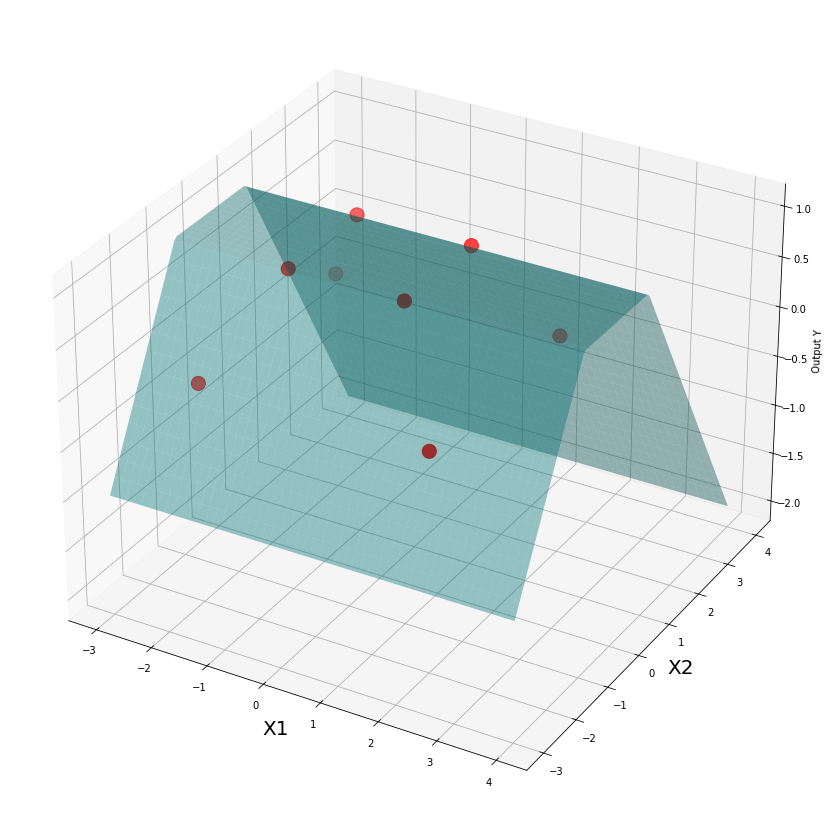

In [20]:
# Create a dense grid of input points
x = np.linspace(-3, 4, 100)  # Adjust the range and density as needed
y = np.linspace(-3, 4, 100)
X_test, Y_test = np.meshgrid(x, y)

# Convert to PyTorch tensors
input_grid = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)

# Evaluate the model on the input grid
model_sgd.eval()  # Set the model to evaluation mode
with torch.no_grad():
    Z = model_sgd(input_grid).numpy()

# Reshape Z for the surface plot
Z = Z.reshape(X_test.shape)

# Create the surface plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_test, Y_test, Z, color='teal', alpha=0.4)

ax.scatter(X_train[:,0], X_train[:,1], train_labels, marker='o', s=200, color='red')

ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Output Y')
plt.show()

## Multi-Task 2 Squares

In [6]:
torch.manual_seed(45)
proxy_tasks = torch.randint(0,2,(100, 8))
multi_task_train_labels = np.vstack([train_labels, proxy_tasks])

In [7]:
multi_task_train_labels.shape

(101, 8)

## Train GD

In [15]:
train_outputs = torch.tensor(multi_task_train_labels).to(torch.float32).T 

# don't include the last column thats for bias when its not built in
train_inputs = torch.tensor(X_train[:,:-1]).to(torch.float32) 

model_sgd_multi_task = ShallowNN(m=64, out_dim=101)

func_norm = []

# Loss and Optimizer
criterion = nn.MSELoss()
#optimizer = optim.Adam(model_sgd.parameters(), lr=0.0001, weight_decay=1e-3)
optimizer = optim.Adam([
    {'params': model_sgd_multi_task.fc1.weight, 'weight_decay': 1e-3},  # Applying weight decay
    {'params': model_sgd_multi_task.fc2.weight, 'weight_decay': 1e-3},
    {'params': model_sgd_multi_task.fc1.bias, 'weight_decay':0}         # No weight decay on bias
], lr=0.0001)


# Training Loop
for epoch in range(200000):  # Number of epochs
    optimizer.zero_grad()
    output = model_sgd_multi_task(train_inputs)
#     print('Output from model is: {}'.format(output))
    loss = criterion(output, train_outputs)
#     print(loss.item())
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        ws_nn = model_sgd_multi_task.fc1.weight.data
        #ws_b = torch.cat((model_sgd.fc1.weight.data, model_sgd.fc1.bias.data.unsqueeze(1)),dim=1)
        vs_nn = model_sgd_multi_task.fc2.weight.data.T

        rep_cost = torch.sum(torch.linalg.norm(vs_nn, dim=1) * torch.linalg.norm(ws_nn, dim=1))
        func_norm.append(rep_cost.item())

    if epoch % 10000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Rep Cost is: {rep_cost.item()}')

print("Training Complete")

# Calculate the sum of squared weights for the fc1 layer
sum_of_squares_fc1 = torch.sum(model_sgd_multi_task.fc1.weight ** 2)
sum_of_squares_fc2 = torch.sum(model_sgd_multi_task.fc2.weight ** 2)

# Total sum of squares for fc1 and the first output weights of fc2
total_sum_of_squares = sum_of_squares_fc1 + sum_of_squares_fc2

print(f"Sum of squared weights (divided by 2): {(total_sum_of_squares/2).item()}")

Epoch 0, Loss: 0.6634354591369629, Rep Cost is: 22.79671287536621
Epoch 10000, Loss: 0.0053075323812663555, Rep Cost is: 30.309383392333984
Epoch 20000, Loss: 0.0037891834508627653, Rep Cost is: 30.081823348999023
Epoch 30000, Loss: 0.0034907704684883356, Rep Cost is: 29.842458724975586
Epoch 40000, Loss: 0.003341277129948139, Rep Cost is: 29.664892196655273
Epoch 50000, Loss: 0.003226677654311061, Rep Cost is: 29.558401107788086
Epoch 60000, Loss: 0.003134290687739849, Rep Cost is: 29.49813461303711
Epoch 70000, Loss: 0.0030594603158533573, Rep Cost is: 29.467788696289062
Epoch 80000, Loss: 0.0029981157276779413, Rep Cost is: 29.460708618164062
Epoch 90000, Loss: 0.002950431779026985, Rep Cost is: 29.469280242919922
Epoch 100000, Loss: 0.002915334654971957, Rep Cost is: 29.48558807373047
Epoch 110000, Loss: 0.002891837153583765, Rep Cost is: 29.50187873840332
Epoch 120000, Loss: 0.0028785939794033766, Rep Cost is: 29.510662078857422
Epoch 130000, Loss: 0.0028699375689029694, Rep Cost 

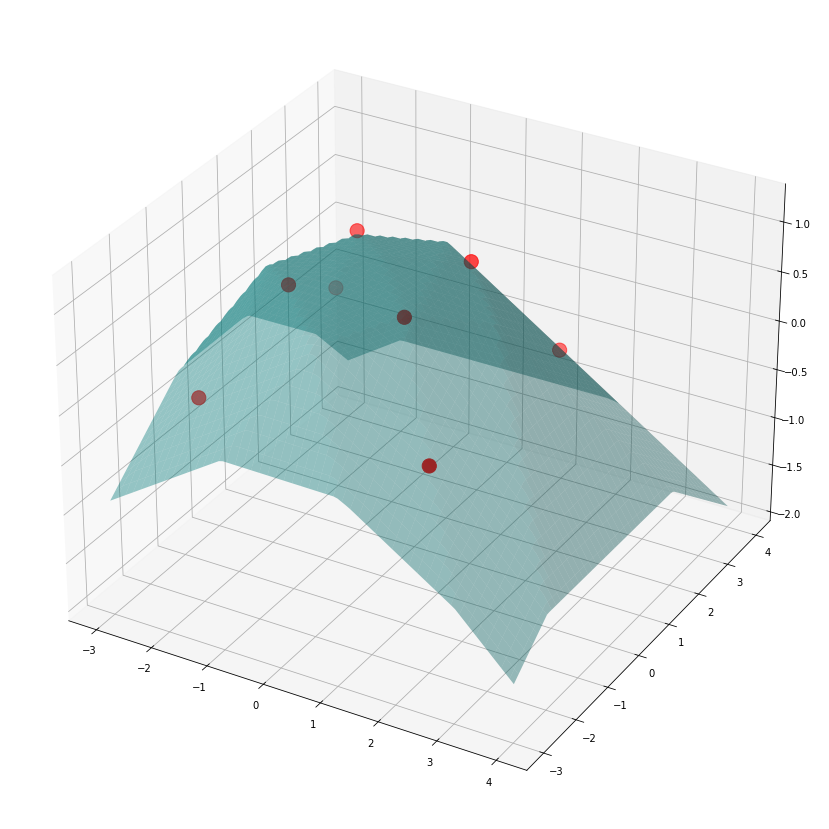

In [17]:
# Create a dense grid of input points
x = np.linspace(-3, 4, 100)  # Adjust the range and density as needed
y = np.linspace(-3, 4, 100)
X_test, Y_test = np.meshgrid(x, y)

# Convert to PyTorch tensors
input_grid = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)

# Evaluate the model on the input grid
model_sgd_multi_task.eval()  # Set the model to evaluation mode
with torch.no_grad():
    Z = model_sgd_multi_task(input_grid)[:,0].numpy()

# Reshape Z for the surface plot
Z = Z.reshape(X_test.shape)

# Create the surface plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_test, Y_test, Z, color='teal', alpha=0.4)

ax.scatter(X_train[:,0], X_train[:,1], train_labels, marker='o', s=200, color='red')
plt.savefig('mtl_gd_sol_2_sqrs.pdf', dpi=500, bbox_inches='tight')
plt.show()

## Extract Features and solve
$$
    \min_{v_{1s}, \dots, v_{Ks}} \sum_{i=1}^N  \mathcal{L} \left(   y_{is}, \sum_{k \in \mathcal{S}} v_{ks} \mathbf{\Phi}_{ik}   \right) + \frac{\lambda}{2} \sum_{k \in \mathcal{S}} \gamma_{k} v_{ks}^2 
$$

In [18]:
vks = model_sgd_multi_task.fc2.weight.detach()

In [19]:
vks.shape

torch.Size([101, 64])

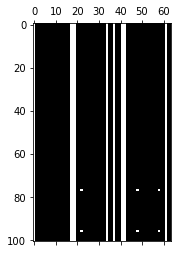

In [20]:
plt.spy(vks, precision=1e-5)
plt.show()

In [21]:
torch.sum(torch.linalg.norm(vks, dim=0) > 1e-3)

tensor(55)

In [22]:
for module in model_sgd_multi_task.modules():
    module._forward_hooks.clear()
    module._backward_hooks.clear()
    module._forward_pre_hooks.clear()
    module._backward_pre_hooks.clear()

In [23]:
features = {}

def get_features(name):
    def hook(model, input, output):
        print(input)
        features[name] = input
    return hook

In [24]:
model_sgd_multi_task.fc2.register_forward_hook(get_features('fc2'))

In [25]:
output = model_sgd_multi_task(train_inputs)

(tensor([[0.0000e+00, 9.2158e-06, 5.9657e-05, 0.0000e+00, 8.4679e-01, 1.1020e+01,
         0.0000e+00, 1.4636e+00, 1.1462e+01, 4.5300e-05, 0.0000e+00, 1.1572e+01,
         0.0000e+00, 1.0625e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 6.8188e-05, 0.0000e+00, 1.3574e-04, 0.0000e+00,
         0.0000e+00, 1.0781e+00, 0.0000e+00, 1.4622e+00, 0.0000e+00, 1.7285e-06,
         1.5689e+00, 1.0451e+00, 7.7963e-05, 4.4346e-05, 0.0000e+00, 0.0000e+00,
         1.4297e+01, 0.0000e+00, 6.7562e-01, 0.0000e+00, 1.4319e+01, 0.0000e+00,
         0.0000e+00, 1.4033e+01, 6.8967e-01, 1.2357e+00, 1.6167e+00, 7.8977e-01,
         4.3213e-06, 1.1572e+00, 9.0247e-01, 0.0000e+00, 0.0000e+00, 1.4233e+01,
         8.6236e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0091e-01,
         1.4392e+01, 0.0000e+00, 0.0000e+00, 8.4384e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6924e+00, 1.1020e+01,
         0.0000e+00, 7.4030e-01, 1.1462e+01, 0.000

In [26]:
Phi = features['fc2'][0].detach()

In [27]:
Phi.shape

torch.Size([8, 64])

In [28]:
gammas = 1 / 2*(torch.linalg.norm(vks,dim=0))

In [29]:
gammas.shape

torch.Size([64])

In [30]:
Phi_np = Phi.numpy()
gammas_np = gammas.numpy()

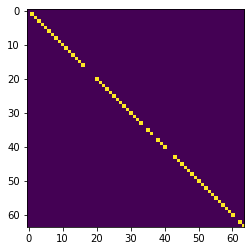

In [31]:
plt.imshow(np.diag(gammas_np > 0))
plt.show()

In [32]:
Phi_clean = Phi_np @ np.diag(gammas_np > 0)

In [33]:
train_labels.shape

(8,)

In [34]:
## Solve RKHS problem using CVXPy
W = np.diag(gammas)

# Regularization parameter (optional)
lambda_reg = 1e-3

# Optimization variable
v = cp.Variable(Phi_clean.shape[1])

# Objective function components
lsq_term = cp.sum_squares(Phi_clean @ v - train_labels)
reg_term = lambda_reg * cp.quad_form(v, W)

# Total objective
objective = cp.Minimize(lsq_term + reg_term)

# Formulate and solve the problem
problem = cp.Problem(objective)
problem.solve()

# Output the results
print("Optimal value:", problem.value)
print("Optimal x:", v.value)

Optimal value: 0.0001258012097640712
Optimal x: [-0.         -0.06483036 -0.12449008 -0.06884804 -0.09416053  0.0212375
 -0.06484368 -0.07489416  0.02123323 -0.10189519 -0.06483187  0.02123154
 -0.07123597  0.02123938 -0.12427582 -0.08785243 -0.07123215 -0.
 -0.         -0.         -0.09517773 -0.06885079 -0.06486113 -0.08786259
 -0.11354252 -0.10439677 -0.0951969  -0.07488626 -0.07123594 -0.09519798
 -0.07488985 -0.09057489 -0.09517626 -0.10189632 -0.         -0.06884799
  0.02120852 -0.         -0.09414255 -0.09847261  0.0212086  -0.
 -0.          0.02121085 -0.09056274 -0.10440752 -0.0748811  -0.09057867
 -0.12450998 -0.07487625 -0.09415818 -0.0688391  -0.07123624  0.02120941
 -0.09056984 -0.09846668 -0.11354469 -0.06884426 -0.06488292 -0.07490642
  0.02120789 -0.         -0.09520112 -0.09415255]


In [35]:
new_v = v.value

In [36]:
import copy
## Construct new neural network with this V
model_copy = copy.deepcopy(model_sgd_multi_task)

In [37]:
with torch.no_grad():
    model_copy.fc2.weight[0,:] = torch.tensor(v.value)

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5955, 3.3729],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6195, 3.3431],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6435, 3.3133],
        ...,
        [0.0000, 4.1776, 0.1527,  ..., 0.0000, 0.6929, 0.0000],
        [0.0000, 4.2152, 0.1527,  ..., 0.0000, 0.7169, 0.0000],
        [0.0000, 4.2528, 0.1527,  ..., 0.0000, 0.7409, 0.0000]]),)


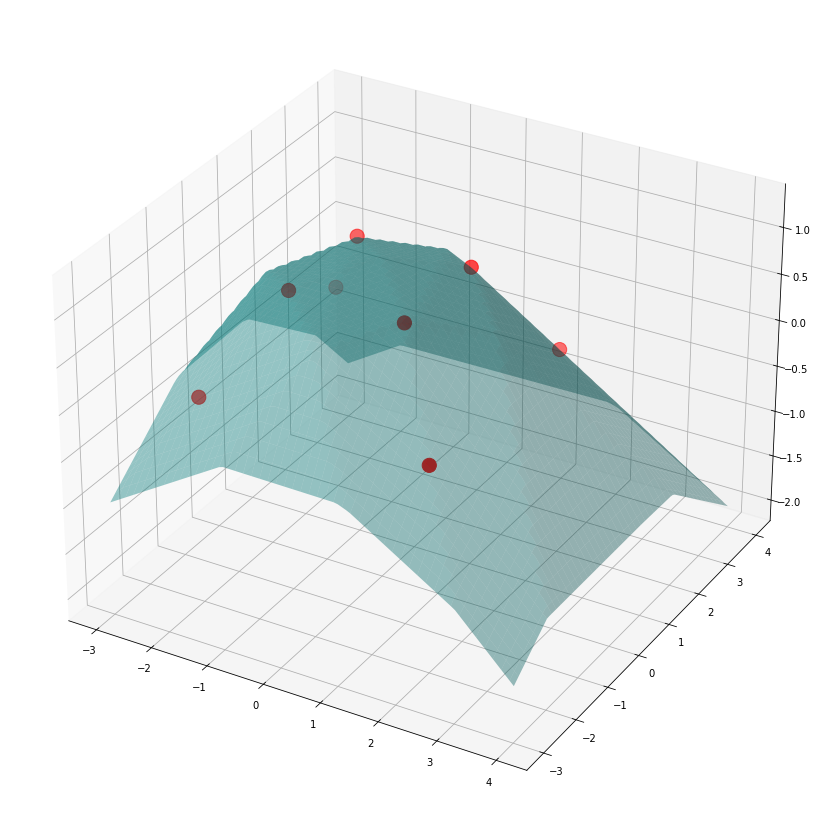

In [38]:
# Create a dense grid of input points
x = np.linspace(-3, 4, 100)  # Adjust the range and density as needed
y = np.linspace(-3, 4, 100)
X_test, Y_test = np.meshgrid(x, y)

# Convert to PyTorch tensors
input_grid = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)

# Evaluate the model on the input grid
model_sgd_multi_task.eval()  # Set the model to evaluation mode
with torch.no_grad():
    Z = model_copy(input_grid)[:,0].numpy()

# Reshape Z for the surface plot
Z = Z.reshape(X_test.shape)

# Create the surface plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_test, Y_test, Z, color='teal', alpha=0.4)

ax.scatter(X_train[:,0], X_train[:,1], train_labels, marker='o', s=200, color='red')

plt.savefig('rkhs_sol_2_sqrs.pdf', dpi=500, bbox_inches='tight')
plt.show()